In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/squeezenet_3channel_scratch.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/val'

SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

### SqueezeNet Model

In [3]:
from keras_squeezenet import SqueezeNet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image

base_model = SqueezeNet(input_shape=(224,224,3))
for layer in base_model.layers:
        layer.trainable = False

snet_extract = base_model.layers[-3].output
snet_extract = tf.keras.layers.GlobalAveragePooling2D()(snet_extract)
snet_extract = tf.keras.layers.Dropout(0.5)(snet_extract)
output = tf.keras.layers.Dense(3, activation='softmax')(snet_extract)

squeezenet_model = Model(base_model.input, output)
squeezenet_model.summary()

2022-08-26 20:07:24.536844: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-26 20:07:24.536907: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5808 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 111, 111, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 relu_conv1 (Activation)        (None, 111, 111, 64  0           ['conv1[0][0]']                  
                                )                                                             

#### Keras Callbacks

In [4]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(squeezenet_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(squeezenet_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.3,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 7566 images belonging to 3 classes.
Found 1551 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.7479240806642942, 1: 0.8135483870967742, 2: 2.3053016453382082}
samples for train class labels: dict_items([(0, 3372), (1, 3100), (2, 1094)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 702), (1, 600), (2, 249)])


#### SqueezeNet Compilation and Execution

In [8]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
squeezenet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [ ]:
warnings.filterwarnings("ignore")
epochs = 15
history = squeezenet_model.fit(train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=validation_generator, 
                                epochs=epochs,
                                verbose = 1,
                                class_weight = class_weights,
                                callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  0.001
Epoch 1/15
237/237 [==============================] - ETA: 0s - loss: 11.1288 - accuracy: 0.3861 - AUC: 0.5493 - precision: 0.3864 - recall: 0.3855
Epoch 00001: val_loss improved from inf to 2.86493, saving model to ./weights/squeezenet_3channel_scratch.hdf5
End of epoch 0. Learning rate: 0.001
237/237 [==============================] - 105s 437ms/step - loss: 11.1288 - accuracy: 0.3861 - AUC: 0.5493 - precision: 0.3864 - recall: 0.3855 - val_loss: 2.8649 - val_accuracy: 0.6738 - val_AUC: 0.8032 - val_precision: 0.6738 - val_recall: 0.6738 - lr: 0.0010
Learning rate:  0.001
Epoch 2/15
237/237 [==============================] - ETA: 0s - loss: 7.6931 - accuracy: 0.4391 - AUC: 0.5985 - precision: 0.4394 - recall: 0.4383
Epoch 00002: val_loss improved from 2.86493 to 1.39793, saving model to ./weights/squeezenet_3channel_scratch.hdf5
End of epoch 1. Learning rate: 0.001
237/237 [==============================] - 103s 436ms/step - loss: 7.6931 - acc

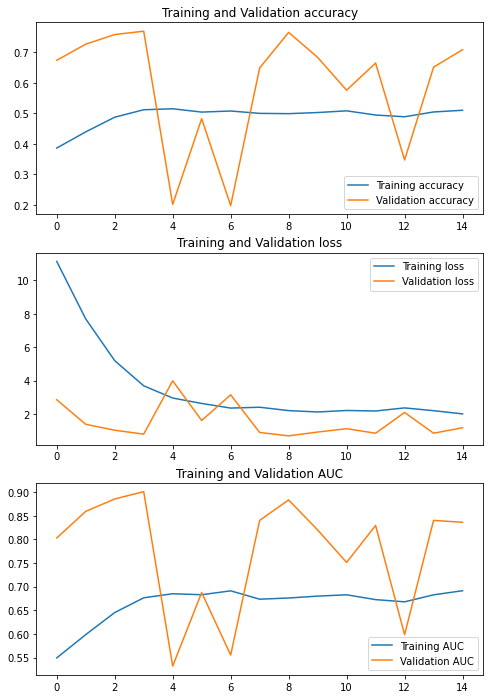

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

In [11]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
8,2.215804,0.498810,0.676070,0.503120,0.490219,0.707659,0.765313,0.883655,0.788219,0.724694,0.001
3,3.697274,0.511631,0.676451,0.512790,0.508723,0.811396,0.769181,0.901139,0.775805,0.760799,0.001
11,2.192656,0.494317,0.672635,0.498773,0.483611,0.864030,0.664732,0.829588,0.692308,0.620890,0.001
13,2.210919,0.504362,0.682784,0.507667,0.494449,0.865035,0.651193,0.840348,0.673023,0.614442,0.001
7,2.417168,0.499736,0.673515,0.503388,0.491012,0.908738,0.648614,0.840354,0.663906,0.620245,0.001
9,2.133418,0.502511,0.680044,0.509643,0.492466,0.934909,0.683430,0.820055,0.709261,0.637008,0.001
2,5.200765,0.487179,0.645265,0.488159,0.484933,1.042933,0.758220,0.885643,0.766754,0.752418,0.001
10,2.223684,0.508062,0.682858,0.512650,0.498150,1.135255,0.575758,0.751345,0.591708,0.542876,0.001
14,2.018909,0.509913,0.691473,0.514877,0.496299,1.193717,0.708575,0.836313,0.713636,0.708575,0.001


In [12]:
for layer in base_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [14]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
squeezenet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

history_finetune = squeezenet_model.fit(train_generator,
                            epochs=35,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 15/35
237/237 [==============================] - ETA: 0s - loss: 0.4936 - accuracy: 0.8029 - AUC: 0.9361 - precision: 0.8409 - recall: 0.7635
Epoch 00015: val_loss improved from 0.70766 to 0.35086, saving model to ./weights/squeezenet_3channel_scratch.hdf5
End of epoch 14. Learning rate: 1e-04
237/237 [==============================] - 102s 423ms/step - loss: 0.4936 - accuracy: 0.8029 - AUC: 0.9361 - precision: 0.8409 - recall: 0.7635 - val_loss: 0.3509 - val_accuracy: 0.8588 - val_AUC: 0.9677 - val_precision: 0.8760 - val_recall: 0.8472 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 16/35
237/237 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8931 - AUC: 0.9768 - precision: 0.9092 - recall: 0.8739
Epoch 00016: val_loss did not improve from 0.35086
End of epoch 15. Learning rate: 1e-04
237/237 [==============================] - 101s 426ms/step - loss: 0.2932 - accuracy: 0.8931 - AUC: 0.9768 - precision: 0.9092 - reca

In [15]:
import pandas as pd
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
19,0.118161,0.954666,0.995642,0.958477,0.951890,0.157553,0.938749,0.992693,0.939276,0.937460,0.0001
17,0.119396,0.954005,0.995639,0.957384,0.950172,0.181021,0.932302,0.990592,0.935023,0.927788,0.0001
16,0.115359,0.957177,0.995792,0.960085,0.953740,0.182614,0.930368,0.990066,0.931951,0.927144,0.0001
14,0.138437,0.948982,0.993863,0.953550,0.944224,0.184608,0.933591,0.990222,0.938762,0.929078,0.0001
15,0.126494,0.952287,0.995016,0.956163,0.948454,0.200940,0.929723,0.987226,0.932468,0.925854,0.0001
18,0.110245,0.959292,0.995999,0.962392,0.957177,0.201198,0.920696,0.987933,0.924479,0.915538,0.0001
10,0.148079,0.942242,0.993591,0.948465,0.938937,0.213368,0.912959,0.987184,0.917701,0.905867,0.0001
5,0.186208,0.929685,0.990240,0.937231,0.921623,0.254307,0.907801,0.981812,0.913072,0.900709,0.0001
11,0.143834,0.945810,0.993800,0.953121,0.940523,0.255510,0.896841,0.982501,0.900520,0.892972,0.0001


In [16]:
history_finetune2 = squeezenet_model.fit(train_generator,
                            epochs=50,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 35/50
237/237 [==============================] - ETA: 0s - loss: 0.1074 - accuracy: 0.9596 - AUC: 0.9963 - precision: 0.9620 - recall: 0.9561
Epoch 00035: val_loss did not improve from 0.15755
End of epoch 34. Learning rate: 1e-04
237/237 [==============================] - 100s 421ms/step - loss: 0.1074 - accuracy: 0.9596 - AUC: 0.9963 - precision: 0.9620 - recall: 0.9561 - val_loss: 0.2859 - val_accuracy: 0.9046 - val_AUC: 0.9799 - val_precision: 0.9091 - val_recall: 0.9033 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 36/50
237/237 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9541 - AUC: 0.9958 - precision: 0.9561 - recall: 0.9502
Epoch 00036: val_loss did not improve from 0.15755
End of epoch 35. Learning rate: 1e-04
237/237 [==============================] - 102s 429ms/step - loss: 0.1189 - accuracy: 0.9541 - AUC: 0.9958 - precision: 0.9561 - recall: 0.9502 - val_loss: 0.2453 - val_accuracy: 0.9104 - val_AUC: 

In [17]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
squeezenet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

history_finetune3 = squeezenet_model.fit(train_generator,
                            epochs=65,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune2.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-05
Epoch 50/65
237/237 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9745 - AUC: 0.9983 - precision: 0.9752 - recall: 0.9733
Epoch 00050: val_loss did not improve from 0.15755
End of epoch 49. Learning rate: 1e-05
237/237 [==============================] - 102s 423ms/step - loss: 0.0682 - accuracy: 0.9745 - AUC: 0.9983 - precision: 0.9752 - recall: 0.9733 - val_loss: 0.3175 - val_accuracy: 0.9033 - val_AUC: 0.9745 - val_precision: 0.9047 - val_recall: 0.8994 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 51/65
237/237 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9779 - AUC: 0.9985 - precision: 0.9791 - recall: 0.9773
Epoch 00051: val_loss did not improve from 0.15755
End of epoch 50. Learning rate: 1e-05
237/237 [==============================] - 100s 424ms/step - loss: 0.0591 - accuracy: 0.9779 - AUC: 0.9985 - precision: 0.9791 - recall: 0.9773 - val_loss: 0.2938 - val_accuracy: 0.9168 - val_AUC: 

#### Test Image Generation for prediction

In [19]:
model =  tf.keras.models.load_model('./weights/squeezenet_3channel_scratch.hdf5')

#### Shenzhen Dataset Evaluation

In [20]:
TEST_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/test/Shenzhen'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = model.predict(test_generator)

Found 134 images belonging to 3 classes.


In [21]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,target_names=['normal','tb'],digits=4)
print(report)

              precision    recall  f1-score   support

      normal     0.9400    0.7121    0.8103        66
          tb     0.7738    0.9559    0.8553        68

    accuracy                         0.8358       134
   macro avg     0.8569    0.8340    0.8328       134
weighted avg     0.8557    0.8358    0.8331       134



#### Montgomery Countery Evaluation

In [22]:
TEST_IMAGE_FOLDER = '/home/TBX11K/MergedBCH/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = model.predict(test_generator)

Found 28 images belonging to 3 classes.


In [23]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,target_names=['normal','tb'],digits=4)
print(report)

              precision    recall  f1-score   support

      normal     0.7857    0.6875    0.7333        16
          tb     0.6429    0.7500    0.6923        12

    accuracy                         0.7143        28
   macro avg     0.7143    0.7188    0.7128        28
weighted avg     0.7245    0.7143    0.7158        28

